In [1]:
%load_ext autoreload
%autoreload 2

import text3d2video.wandb_util as wu
from text3d2video.artifacts.vertex_atributes_artifact import VertAttributesArtifact
from text3d2video.artifacts.animation_artifact import AnimationArtifact

In [6]:
features_3d_artifact_tag = "deadpool-3d-features:latest"
animation_tag = "rumba:latest"

features_3d = VertAttributesArtifact.from_wandb_artifact_tag(
    features_3d_artifact_tag, download=True
)
mv_features = features_3d.get_mv_features_from_lineage()

animation = wu.get_artifact(animation_tag)
animation = AnimationArtifact.from_wandb_artifact(animation)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb:   1 of 1 files downloaded.  


In [8]:
features_multidict = features_3d.get_features_disk_dict()

features_multidict.keys()

[{'layer': 'down_blocks.0.attentions.0.transformer_blocks.0.attn1',
  'timestep': '10'}]

In [12]:
from scripts.generate_video import render_feature_images

# render all feature images
all_feature_images = render_feature_images(
    features_3d, mv_features, animation, animation.frame_nums(sample_n=8), [10]
)

{'layer': 'down_blocks.0.attentions.0.transformer_blocks.0.attn1', 'timestep': '10'}


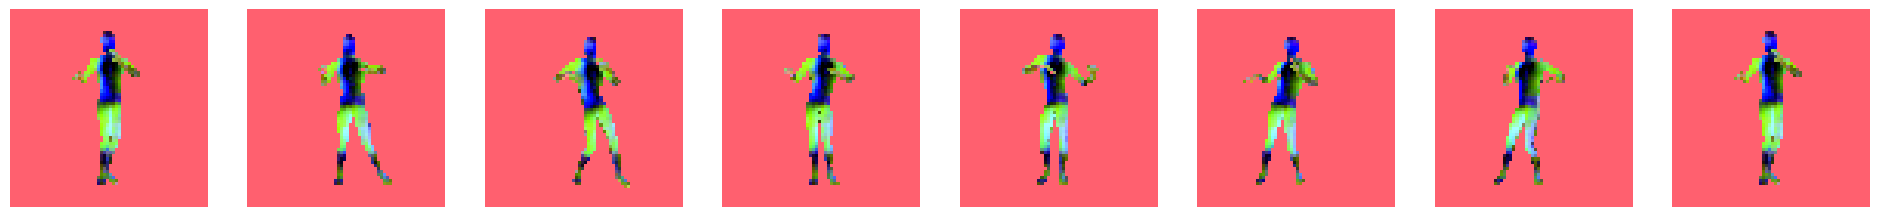

In [14]:
from einops import rearrange

from text3d2video.visualization import RgbPcaUtil
import numpy as np
import matplotlib.pyplot as plt

n_frames = all_feature_images.values()[0].shape[0]

n_rows = len(all_feature_images.keys())
n_cols = n_frames

scale = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * scale, n_rows * scale))

if n_rows == 1:
    axs = np.expand_dims(axs, axis=0)

for row_i, (identifier, feature_images) in enumerate(all_feature_images.items()):
    print(identifier)

    features_flat = rearrange(feature_images, "b c h w -> (b h w) c")
    pca = RgbPcaUtil.init_and_fit(features_flat.cpu())
    rgb_feature_images_pil = [
        pca.feature_map_to_rgb_pil(feature_image) for feature_image in feature_images.cpu()
    ]

    for col_i, rgb_feature_image_pil in enumerate(rgb_feature_images_pil):
        axs[row_i, col_i].imshow(rgb_feature_image_pil)
        axs[row_i, col_i].axis("off")